# Covid Classifier

**Data source** Unknown. 25 X-Ray COVID-19 images and 25 X-Ray non COVID-19 images

**Purpose**: The goal of this notebook is to build a covid classifier out of chest x-rays images and compare results using different models (Sklearn RandomForestClassifier and TensorFlow Keras API).

**Actions**:
1. We did a quick EDA and prepared the data for the model
2. Run RandomForestClassifier Model
3. Run 2x Multi Layer Perceptron models using TensorFlow Keras API
4. Run 1x Convolutional Neural Network using TensorFlow Keras API
5. Saving the model as .keras file

**Future work:**
- data augmentation to increase the size of the training set
- use pre-trained image classification models and mount a second model on top to achieve smoother convergence. 
- use hyperparameter fine-tuning to achieve better results.
- increase real dataset with this Kaggle repo: https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia

Notebook made by: José Maria Trindade

#### Notes on the work
1. Given that is a binary classification, we should use  a sigmoid activation function in the output layer. However, when we are in a multiple class classification, the number of output neurons should be the number of possible classes and using the activation function as a softmax.
2. Label encoder: If this was a multi-class classification problem and we were using a softmax activation function in the output layers, we couldn't have a label array with yes/no. That is only for a binary classification. Instead we should have a vector.
3. There is no need to convert the image into gray scale (1-color channel). We can just adjust the input layer receving shape [224,224,3]. **HOWEVER** the gray scale seemed to converge faster in comparision to 3 color channel code.

#### Import Section

In [1]:
from pathlib import Path
from imutils import paths
import cv2
import matplotlib.pyplot as plt
import os

from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras

import numpy as np
import seaborn as sns
import pandas as pd

#!pip3 install imutils
#!pip3 install opencv-python
#!pip3 install scikit-image

2024-05-14 01:24:21.427291: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Dataset loading

In [2]:
# Setting the dataset paths
dataset = 'datasets/'

""" Look over the images in our dataset 
and then initialize our data and labels list
"""

imagePaths = list(paths.list_images(dataset))
data = []
labels = []

# Loop over the image paths
for imagePath in imagePaths:

    # Extract the class label from the file path (covid19 or no_covid19)
    label = imagePath.split(os.path.sep)[-2]
    """ 
    Load the image, swap color channels, and resize it to be a fixed
    224x224 pixels while ignoring aspect ratio . This will make the images
    equal in size so that they are ready for our CNN
    """
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # Update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

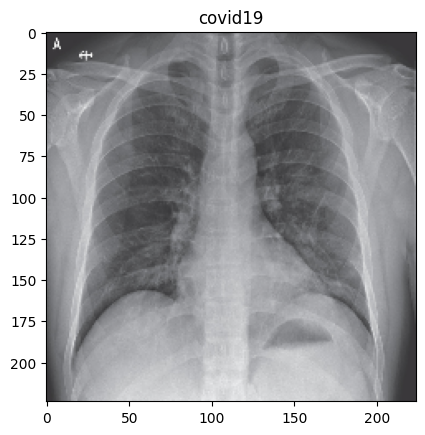

In [3]:
plt.title(labels[0])
plt.grid(False)
plt.imshow(data[0])
plt.show()

### EDA

#### - Target

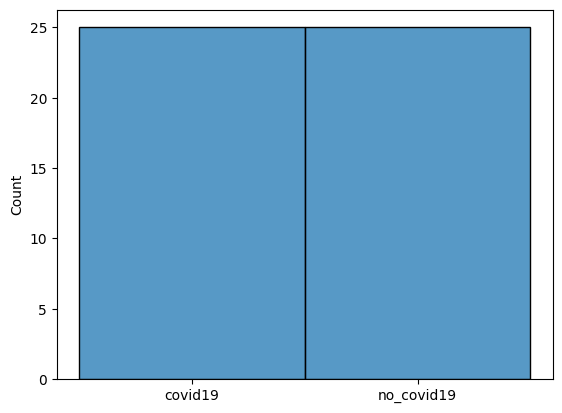

In [4]:
sns.histplot(labels)
plt.show()

- There is class balance. Equal number of positive and negatives labels
- Very little values. Model proned to overfit

In [5]:
# Encoding the target variable
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_encoded = 1 - labels_encoded
labels_encoded = np.array(labels_encoded)

class_names = ["no_covid19","covid19"]

#### - Input Data

In [6]:
# Data
print(type(data))
print(len(data))
print(type(data[0]))
print(data[0].shape)

<class 'list'>
50
<class 'numpy.ndarray'>
(224, 224, 3)


- We have a collection of 50 images 224x224 and in RGB scale
- Before we move the images into the neural network the color scale needs to be normalized

In [7]:
# Data Preparation
data_prepared = []

for image in data:

    # RGB to Gray scale - values go to 0-1
    image_grey = rgb2gray(image)
    
    # Append the flattened image to the list
    data_prepared.append(image_grey)

# Convert the list of flattened images to a numpy array
data_prepared = np.array(data_prepared)

In [8]:
data_prepared.shape

(50, 224, 224)

### Modelling

##### (Baseline) Model Sklearn RandomForestClassifier
- 64% Train, 16% Validation, 20% Test
- Default settings

In [9]:
# Full train and Test set
X_train_full, X_test, y_train_full, y_test = train_test_split(data_prepared, labels_encoded, test_size=0.2, random_state=42)
print(X_train_full.shape)
print(X_test.shape)
print(y_train_full.shape)
print(y_test.shape)

(40, 224, 224)
(10, 224, 224)
(40,)
(10,)


In [10]:
# Train and Validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(32, 224, 224)
(8, 224, 224)
(32,)
(8,)


In [11]:
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train_reshaped = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')

X_train_reshaped.shape

(32, 50176)

In [12]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train_reshaped, y_train)

RandomForestClassifier(random_state=0)

In [13]:
num_pixels_test = X_test.shape[1] * X_test.shape[2]
X_test_reshaped = X_test.reshape(X_test.shape[0], num_pixels_test).astype('float32')

clf.score(X_test_reshaped, y_test)

1.0

In [14]:
y_pred_clf = clf.predict(X_test_reshaped)
print(classification_report(y_true=y_test,
                            y_pred=y_pred_clf,
                            target_names=class_names))

              precision    recall  f1-score   support

  no_covid19       1.00      1.00      1.00         7
     covid19       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



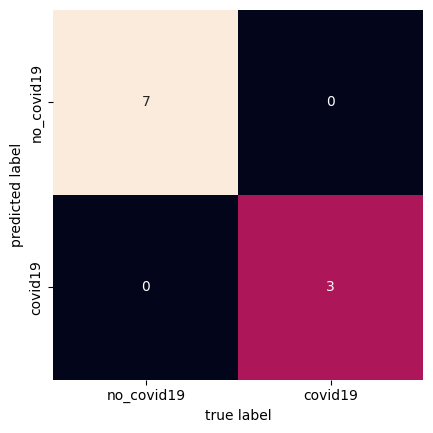

In [15]:
mat = confusion_matrix(y_test, y_pred_clf)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

##### Model 1 TensorFlow Keras Sequential Neural Network
- 64% Train, 16% Validation, 20% Test
- 3 hidden dense layers (500,100,100)
- 1 output layer with 1 units (binary) and sigmoid activation for classification.
- 60 epochs.

In [16]:
np.random.seed(42)
keras.backend.clear_session()
tf.random.set_seed(42)

In [17]:
# Full train and Test set
X_train_full, X_test, y_train_full, y_test = train_test_split(data_prepared, labels_encoded, test_size=0.2, random_state=42)
print(X_train_full.shape)
print(X_test.shape)
print(y_train_full.shape)
print(y_test.shape)

(40, 224, 224)
(10, 224, 224)
(40,)
(10,)


In [18]:
# Train and Validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(32, 224, 224)
(8, 224, 224)
(32,)
(8,)


In [19]:
model_1 = keras.models.Sequential([
    keras.layers.Input(shape=(224,224)),
    keras.layers.Flatten(),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")])

In [20]:
model_1.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [21]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │    25,088,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,148,801 (95.94 MB)

 Trainable params: 25,148,801 (95.94 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model_1.layers[1].get_weights()[0] # Weights

array([[ 0.00091908, -0.00194405,  0.00554334, ..., -0.00681282,
        -0.00242472, -0.00380086],
       [-0.01028437,  0.00551864, -0.00885862, ...,  0.00169144,
         0.01023468,  0.00576583],
       [-0.00151437,  0.0090016 , -0.00832757, ...,  0.0085518 ,
         0.00492533, -0.00119524],
       ...,
       [-0.00345127, -0.00492354, -0.00054415, ..., -0.00308653,
         0.00293415, -0.00351852],
       [ 0.00187257,  0.0018593 , -0.0068824 , ..., -0.00275223,
         0.00583711, -0.00670639],
       [-0.01046375,  0.00238146, -0.00383529, ..., -0.0094247 ,
        -0.00674343, -0.00881624]], dtype=float32)

In [23]:
history = model_1.fit(X_train, y_train, epochs=60,
                    validation_data=(X_val, y_val),)

Epoch 1/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 0.6838 - val_accuracy: 0.6250 - val_loss: 0.6410
Epoch 2/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5312 - loss: 0.7828 - val_accuracy: 0.3750 - val_loss: 1.1338
Epoch 3/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.4688 - loss: 0.9423 - val_accuracy: 0.6250 - val_loss: 0.6247
Epoch 4/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5312 - loss: 0.7762 - val_accuracy: 0.3750 - val_loss: 1.2703
Epoch 5/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.4688 - loss: 1.0400 - val_accuracy: 0.6250 - val_loss: 0.6455
Epoch 6/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5312 - loss: 0.8074 - val_accuracy: 0.3750 - val_loss: 0.8738
Epoch 7/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.4688 - loss: 0.7793 - val_accuracy: 0.6250 - val_loss: 0.6562
Epoch 8/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.5312 - loss: 0.8422 - val_accuracy: 0.3750 - val_loss: 0.

- Model Evaluation

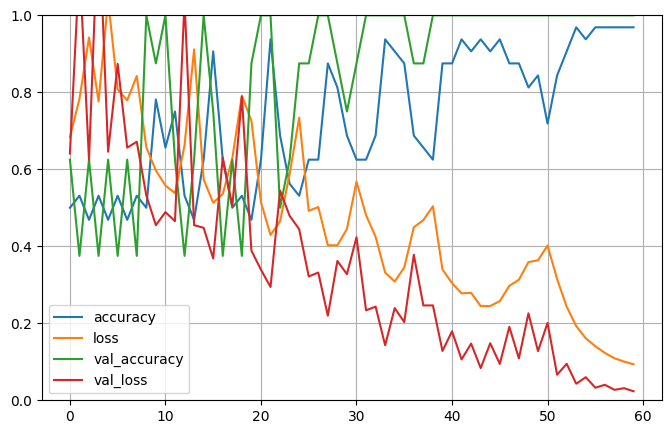

In [24]:
# Plotting the Accuracy and Loss
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [25]:
loss, accuracy = model_1.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0614
Test Loss: 0.06135183572769165
Test Accuracy: 1.0


In [26]:
X_new = X_test[:8]
y_proba = model_1.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


In [27]:
y_pred=np.argmax(y_proba,axis=1)
np.array(class_names)[y_pred]

array(['no_covid19', 'no_covid19', 'no_covid19', 'no_covid19',
       'no_covid19', 'no_covid19', 'no_covid19', 'no_covid19'],
      dtype='<U10')

In [28]:
np.array(class_names)[y_test[:8]]

array(['covid19', 'no_covid19', 'no_covid19', 'no_covid19', 'covid19',
       'no_covid19', 'no_covid19', 'no_covid19'], dtype='<U10')

##### Model 2 TensorFlow Keras Sequential Neural Network
- 70% Train, 15% Validation, 15% Test
- 2 hidden dense layers (64,32)
- 1 output layer with 1 units (binary) and sigmoid activation for classification.
- 50 epochs.

In [29]:
np.random.seed(42)
keras.backend.clear_session()
tf.random.set_seed(42)

In [30]:
# Full train and Test set
X_train, X_test_full, y_train, y_test_full = train_test_split(data_prepared, labels_encoded, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test_full.shape)
print(y_train.shape)
print(y_test_full.shape)

(35, 224, 224)
(15, 224, 224)
(35,)
(15,)


In [31]:
# Validation and Test set
X_test, X_val, y_test, y_val = train_test_split(X_test_full, y_test_full, test_size=0.5, random_state=42)
print(X_test.shape)
print(X_val.shape)
print(y_test.shape)
print(y_val.shape)

(7, 224, 224)
(8, 224, 224)
(7,)
(8,)


In [32]:
model_2 = keras.models.Sequential([
    keras.layers.Input(shape=(224,224)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")])

In [33]:
model_2.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [34]:
history = model_2.fit(X_train, y_train, epochs=50,
                    validation_data=(X_val, y_val),)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.5789 - loss: 0.6754 - val_accuracy: 0.5000 - val_loss: 1.1088
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4905 - loss: 1.6140 - val_accuracy: 0.5000 - val_loss: 1.0571
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4905 - loss: 1.4264 - val_accuracy: 0.5000 - val_loss: 0.6463
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5095 - loss: 0.6696 - val_accuracy: 0.5000 - val_loss: 0.6360
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5095 - loss: 0.6670 - val_accuracy: 0.5000 - val_loss: 0.6190
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5095 - loss: 0.6464 - val_accuracy: 0.5000 - val_loss: 0.5863
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5286 - loss: 0.6192 - val_accuracy: 0.5000 - val_loss: 0.6182
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5286 - loss: 0.6793 - val_accuracy: 0.8750 - val_loss: 0.4731

- Model Evaluation

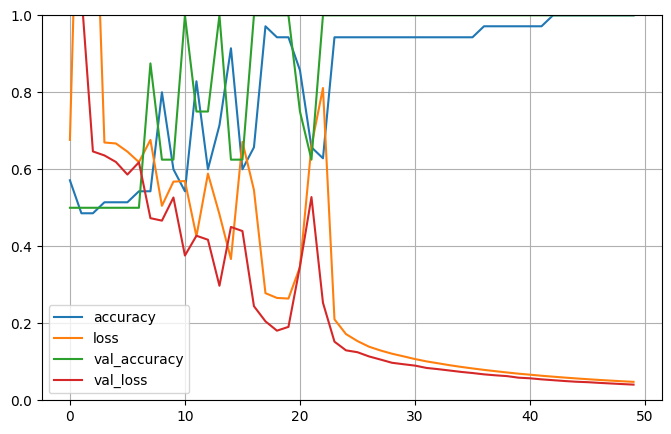

In [35]:
# Plotting the Accuracy and Loss
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [36]:
loss, accuracy = model_2.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0484
Test Loss: 0.04841897636651993
Test Accuracy: 1.0


##### Model 3 TensorFlow Keras Sequential - Convulutional Neural Network
- 70% Train, 15% Validation, 15% Test
- 1 convolutional layer with 16 filters, followed by a max pooling layer
- 1 hidden dense layer (32)
- 1 output layer with 1 units (binary) and sigmoid activation for classification.
- 30 epochs.

In [37]:
np.random.seed(42)
keras.backend.clear_session()
tf.random.set_seed(42)

In [38]:
X_train_reshaped = X_train.reshape(-1, 224, 224, 1)
X_val_reshaped = X_val.reshape(-1, 224, 224, 1)
X_test_reshaped = X_test.reshape(-1, 224, 224, 1)

In [39]:
model_3 = keras.models.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224,1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_3.fit(X_train_reshaped, y_train, epochs=30, validation_data=(X_val_reshaped, y_val))

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step - accuracy: 0.5685 - loss: 0.7062 - val_accuracy: 0.5000 - val_loss: 7.3291
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.4905 - loss: 6.6230 - val_accuracy: 0.5000 - val_loss: 0.8662
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.5095 - loss: 0.8320 - val_accuracy: 0.5000 - val_loss: 4.0623
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.5095 - loss: 4.8469 - val_accuracy: 0.5000 - val_loss: 2.7550
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.5095 - loss: 3.4119 - val_accuracy: 0.7500 - val_loss: 0.3709
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.9030 - loss: 0.3314 - val_accuracy: 0.5000 - val_loss: 2.0525
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.5095 - loss: 1.4247 - val_accuracy: 0.7500 - val_loss: 0.3282
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step - accuracy: 0.9411 - loss: 0.1903 - val_accuracy: 1.0000 - val_loss: 0.0978
Epo

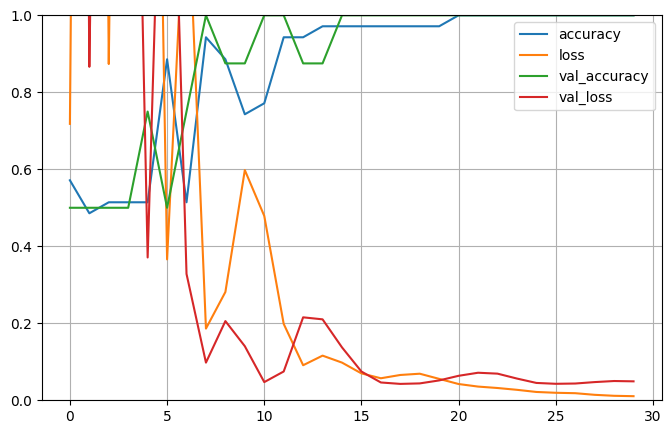

In [40]:
# Plotting the Accuracy and Loss
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

**Use of CNNs for Image Classification tasks**

Chat GPT 3.5: Convolutional neural networks (CNNs) are particularly effective for image classification tasks due to their ability to capture spatial hierarchies of features in the data. This spatial hierarchy enables CNNs to learn patterns and relationships between pixels at different levels of abstraction, making them well-suited for processing images.

CNNs leverage convolutional layers to extract local features from input images, followed by pooling layers to downsample the feature maps and reduce computational complexity. These layers are designed to preserve spatial relationships and exploit the local structure of images, allowing CNNs to learn hierarchical representations of features directly from pixel values.

Compared to traditional fully connected neural networks, CNNs often converge faster and achieve better performance in image classification tasks. This is because CNNs can learn meaningful representations of image data with fewer parameters, thanks to weight sharing and local connectivity in convolutional layers. Additionally, the hierarchical nature of CNN architectures enables them to capture both low-level features (e.g., edges, textures) and high-level features (e.g., shapes, objects) in the input images.

In summary, convolutional neural networks can significantly speed up convergence and improve performance in image classification tasks by leveraging the spatial hierarchy of features present in images. If your dataset consists of images, using CNNs is generally recommended for better results.

### Conclusions

The scope of this assignment was to compare the performance between different tensorflow neural nets, and therefore we will not consider the baseline model and the convolutional neural network for this comparison.

Nonethless, one needs to acknowledge 1) the high performance of the baseline model achieving 100% accuracy in the test dataset; 2) the fact that CNNs are the best architecture for image classification tasks, as it converges to optimal values in a much faster and efficient way. In fact, this net only needed 20 epochs to achieve max accuracy in both training and validation sets, and very little losses.

**Comparing the two pure neural networks,the model that converged faster (less epochs) to max accuracy and min loss was the simple net with only 2 hidden dense layers (64,32). This result is interesting as it can mean that simpler configuration can achieve better results in small datasets like this one.**

### Saving and Loading Model

In [41]:
# Saving full model to disc
model_2.save("my_saved_keras_model.keras")

In [42]:
# Loading model from disc
loaded_model = keras.models.load_model("my_saved_keras_model.keras")

In [43]:
# Checking its performance
loss, accuracy = loaded_model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 1.0000 - loss: 0.0484
Test Loss: 0.04841897636651993
Test Accuracy: 1.0


Note: Same performance results as when not loading the model.